Let's see if we can load up some objects, integrate positions, then convert to RA,dec

In [1]:
import assist
import astropy.units as u
from astropy.coordinates import SkyCoord, HeliocentricTrueEcliptic, ICRS,GCRS, GeocentricMeanEcliptic, GeocentricTrueEcliptic,EarthLocation


from astropy.time import Time
import rebound
from rubin_sim.moving_objects import Orbits
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
ephem = assist.Ephem("/Users/yoachim/rubin_sim_data/linux_p1550p2650.440", "/Users/yoachim/rubin_sim_data/sb441-n16.bsp")
time = Time(ephem.jd_ref, format="jd")
part = ephem.get_particle("Earth", 0)

In [3]:
part

<rebound.particle.Particle object at 0x168c30950, m=8.887692446707103e-10 x=-0.18427227843428148 y=0.8847811839446426 z=0.3838199903352723 vx=-0.017202246608380413 vy=-0.002904925902856414 vz=-0.0012594279121938968>

In [4]:
sc = SkyCoord(x=part.x*u.au, y=part.y*u.au, z=part.z*u.au, 
              representation_type='cartesian', obstime=time,
              frame=HeliocentricTrueEcliptic)

In [5]:
# Ah, so this is the RA,dec from the sun probably, that's why it keeps giving me ~1 AU dist
sc.transform_to(ICRS)

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, AU)
    (106.26080804, 45.80030658, 0.98082243)>

In [6]:
sc.transform_to(GeocentricTrueEcliptic)

<SkyCoord (GeocentricTrueEcliptic: equinox=J2000.000, obstime=2451545.0): (lon, lat, distance) in (deg, deg, AU)
    (264.99110241, 77.82741269, 0.39264972)>

In [7]:
sim = rebound.Simulation()
extras = assist.Extras(sim, ephem)

# If we are using orbital elements, need to put the sun in. Maybe the rest of the bodies too, I'm confused?
t_initial = 0 # Julian Days relative to jd_ref
sun_initial = ephem.get_particle("sun", t_initial)
sim.add(sun_initial)
        

In [8]:
help(sim.add)

Help on method add in module rebound.simulation:

add(particle=None, **kwargs) method of rebound.simulation.Simulation instance
    Adds a particle to REBOUND. Accepts one of the following:

    1) A single Particle structure.
    2) The particle's mass and a set of cartesian coordinates: m,x,y,z,vx,vy,vz.
    3) The primary as a Particle structure, the particle's mass and a set of orbital elements: primary,m,a,anom,e,omega,inv,Omega,MEAN (see :class:`.Orbit` for the definition of orbital elements).
    4) A name of an object (uses NASA Horizons to look up coordinates)
    5) A list of particles or names.



In [9]:
rs_orbits = Orbits()
rs_orbits.read_orbits("/Users/yoachim/rubin_sim_data/orbits/granvik_5k.txt")
#rs_orbits.read_orbits("/Users/yoachim/rubin_sim_data/orbits/occ_rmax20_5k.txt")

N_objects = rs_orbits.orbits.shape[0]

In [10]:
rs_orbits.orbits

,a,e,inc,Omega,argPeri,meanAnomaly,epoch,H,objId,g,sed_filename,obj_id
0,1.810322,0.457012,8.524691,321.309082,218.878296,194.936127,59853.0,24.902994,242880,0.15,S.dat,0
1,1.390497,0.458398,43.303799,232.109802,241.479919,91.117035,59853.0,24.474217,175331,0.15,S.dat,1
2,1.657430,0.493258,5.164651,302.836609,266.812195,161.882599,59853.0,23.124664,647396,0.15,S.dat,2
3,2.073438,0.554929,10.493196,185.436066,139.102676,261.443756,59853.0,24.706829,492747,0.15,S.dat,3
4,1.338621,0.133787,39.041023,341.855743,186.264435,40.988487,59853.0,24.607513,546031,0.15,S.dat,4
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1.624333,0.446512,54.509521,355.366943,314.864990,99.870674,59853.0,23.640100,23696,0.15,S.dat,4995
4996,2.984417,0.763269,41.823479,333.647278,74.136383,7.006821,59853.0,24.729494,33632,0.15,C.dat,4996
4997,1.787739,0.404088,23.665245,351.980927,102.490379,126.487000,59853.0,24.963896,214385,0.15,S.dat,4997
4998,2.174124,0.421286,4.020179,38.037006,138.996429,290.406464,59853.0,24.503445,106108,0.15,S.dat,4998


In [11]:
# now to convert each orbit to a particle
for i in range(rs_orbits.orbits.shape[0]):
    row = rs_orbits.orbits.iloc[i]
    part = rebound.Particle(sim, a=row["a"], e=row["e"], inc=np.radians(row["inc"]), Omega=np.radians(row["Omega"]),
                            omega=np.radians(row["argPeri"]), M=np.radians(row["meanAnomaly"]))
    
    sim.add(part)

In [12]:
help(sim.add)

Help on method add in module rebound.simulation:

add(particle=None, **kwargs) method of rebound.simulation.Simulation instance
    Adds a particle to REBOUND. Accepts one of the following:

    1) A single Particle structure.
    2) The particle's mass and a set of cartesian coordinates: m,x,y,z,vx,vy,vz.
    3) The primary as a Particle structure, the particle's mass and a set of orbital elements: primary,m,a,anom,e,omega,inv,Omega,MEAN (see :class:`.Orbit` for the definition of orbital elements).
    4) A name of an object (uses NASA Horizons to look up coordinates)
    5) A list of particles or names.



In [13]:
t_final = 365*5
N_samples_time =365*5
times = np.linspace(t_initial, t_final, N_samples_time, endpoint=True)

positions = np.zeros((N_samples_time, N_objects, 3))

for i, t in enumerate(times):
    extras.integrate_or_interpolate(t)
    for j in range(N_objects):
        # Need +1 to skip sun
        positions[i,j] = sim.particles[j+1].xyz

In [14]:
sim.particles[5].xyz

[0.843646652614617, -1.0298409644032418, -0.5815129742944708]

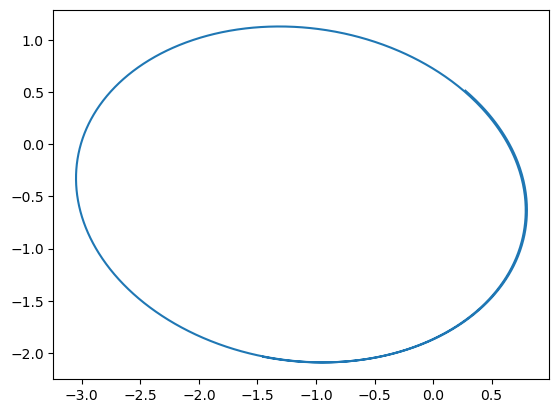

In [15]:
plt.plot(positions[:,100,0], positions[:,100,1])

In [16]:


location = EarthLocation.of_site('LSST')
apt = Time(times+ephem.jd_ref, format="jd")

sc = SkyCoord(x=positions[:,100,0]*u.au, y=positions[:,100,1]*u.au, z=positions[:,100,2]*u.au, 
              representation_type='cartesian', obstime=apt,
              frame=HeliocentricTrueEcliptic, location=location)



In [17]:
ack = sc.transform_to(ICRS)

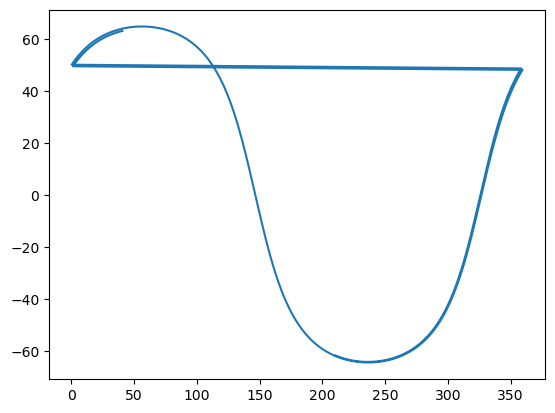

In [18]:
plt.plot(ack.ra, ack.dec)

In [19]:
ack = sc.transform_to(GCRS)

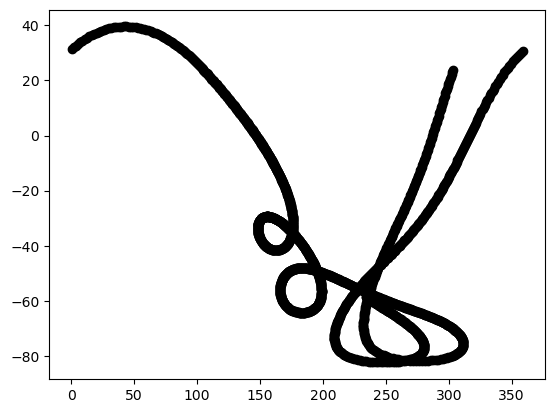

In [20]:
# Ah, there we go, need to go to GCRS
plt.plot(ack.ra, ack.dec, 'ko')

In [21]:
# Looks like this is from the center of the earth. Which is probably close enough. 
ack

<SkyCoord (GCRS: obstime=[2451545.         2451546.00054825 2451547.00109649 ... 2453367.99890351
 2453368.99945175 2453370.        ], obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec, distance) in (deg, deg, AU)
    [(233.8307102 , -58.57827112, 4.13880165),
     (234.31865993, -58.71656806, 4.12829715),
     (234.80750161, -58.8550869 , 4.11767369), ...,
     (302.15233264,  22.13549807, 0.87451274),
     (302.83218208,  23.02676496, 0.86364034),
     (303.53235781,  23.92666642, 0.85275669)]>